<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/bayes_stats/pymc3_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief introduction to [PyMC3](https://docs.pymc.io/)

PyMC3 is a library that lets the user specify certain kinds of joint probability models using a Python API, that has the "look and feel" similar to the standard way of present hierarchical Bayesian models. Once the (log) joint is defined, it can be used for posterior inference, using either various algorithms, including Hamiltonian Monte Carlo (HMC), and automatic differentiation variational inference (ADVI). More details can be found on the [PyMC3 web page](https://docs.pymc.io/), and in the book [Bayesian Analysis with Python (2nd end)](https://github.com/aloctavodia/BAP) by Osvaldo Martin..

In [1]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd

In [2]:
!pip install pymc3==3.8
import pymc3 as pm
pm.__version__


!pip install arviz
import arviz as az

     |████████████████████████████████| 911kB 8.8MB/s 
     |████████████████████████████████| 1.5MB 15.5MB/s 
     |████████████████████████████████| 737kB 50.3MB/s 
     |████████████████████████████████| 4.7MB 43.4MB/s 
     |████████████████████████████████| 296kB 50.7MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


## Example: 1d Gaussian with unknown mean.

We use the simple example from the [Pyro intro](https://pyro.ai/examples/intro_part_ii.html#A-Simple-Example). The goal is to infer the weight $\theta$ of an object, given noisy measurements $y$. We assume the following model:
$$
\begin{align}
\theta &\sim N(\mu=8.5, \tau^2=1.0)\\ 
y \sim &N(\theta, \sigma^2=0.75^2)
\end{align}
$$

Where $\mu=8.5$ is the initial guess. 

By Bayes rule for Gaussians, we know that the exact posterior,
given a single observation $y=9.5$, is given by


$$
\begin{align}
\theta|y &\sim N(m, s^s) \\
m &=\frac{\sigma^2 \mu + \tau^2 y}{\sigma^2 + \tau^2} 
  = \frac{0.75^2 \times 8.5 + 1 \times 9.5}{0.75^2 + 1^2}
  = 9.14 \\
s^2 &= \frac{\sigma^2 \tau^2}{\sigma^2  + \tau^2} 
= \frac{0.75^2 \times 1^2}{0.75^2 + 1^2}= 0.6^2
\end{align}
$$

In [3]:
mu = 8.5; tau = 1.0; sigma = 0.75; y = 9.5
m = (sigma**2 * mu + tau**2 * y)/(sigma**2 + tau**2)
s2 = (sigma**2 * tau**2)/(sigma**2 + tau**2)
s = np.sqrt(s2)
print(m)
print(s)

9.14
0.6


In [4]:
# Specify the model

with pm.Model() as model:
  theta = pm.Normal('theta', mu=m, sd=tau)
  obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)


#MCMC inference

In [5]:

# run MCMC (defaults to 2 chains)
with model:
    trace = pm.sample(1000, random_seed=123)

az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 2401.34it/s]
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,9.369,0.594,8.263,10.532,0.02,0.014,911.0,909.0,890.0,1273.0,1.0


In [ ]:
samples = trace['theta']
print(samples.shape)
post_mean = np.mean(samples)
post_std = np.std(samples)
print([post_mean, post_std])

(2000,)
[9.383772725220332, 0.5950231559728297]


# Variational inference


We use automatic differentiation VI.
Details can be found at https://docs.pymc.io/notebooks/variational_api_quickstart.html

In [6]:
niter = 10000
with model:
    post = pm.fit(niter, method='advi'); # mean field approximation

Average Loss = 1.1905: 100%|██████████| 10000/10000 [00:04<00:00, 2428.85it/s]
Finished [100%]: Average Loss = 1.1904


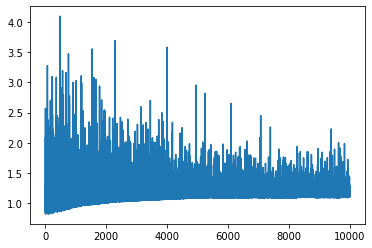

In [7]:
# Plot negative ELBO vs iteration to assess convergence
plt.plot(post.hist);

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


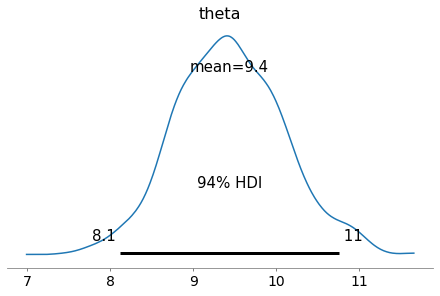

In [8]:
pm.plot_posterior(post.sample(1000));

In [19]:
draws = post.sample(1000)
samples = draws['theta']

print(samples.shape)
post_mean = np.mean(samples)
post_std = np.std(samples)
print([post_mean, post_std])


(1000,)
[9.376825865917606, 0.6503940462406219]


# PyMc3 Libraries

The [arviz](https://github.com/arviz-devs/arviz) library can be used to visualize (and diagonose problems with) posterior samples drawn from many libraries, including PyMc3.

The [PyMc-learn](https://pymc-learn.readthedocs.io/en/latest/) library offers a sklearn-style API to specify models, but uses PyMc3 under the hood to compute posteriors for model parameters, instead of just point estimates.


